In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math

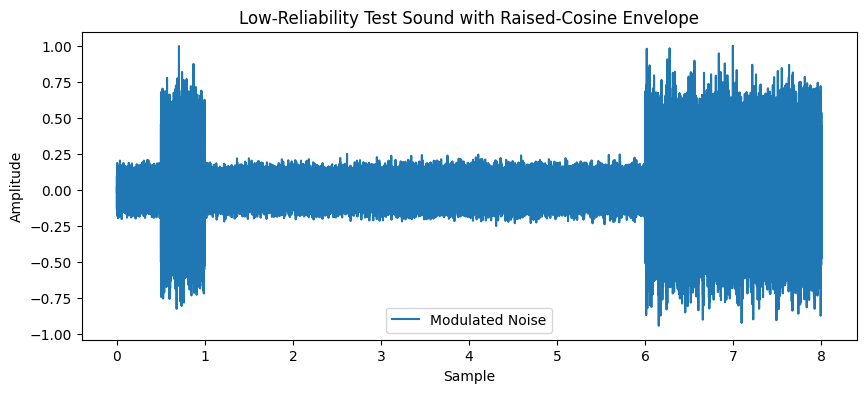

In [2]:
from audio_cue_generator import AudioCueGenerator
audio_cue =AudioCueGenerator()
#test_noise_stimulus = audio_cue.generate_intensity_increment_noise(duration=2,increment_start=1, increment_duration=0.3, noise_type="white")


# Run Low Reliability Test

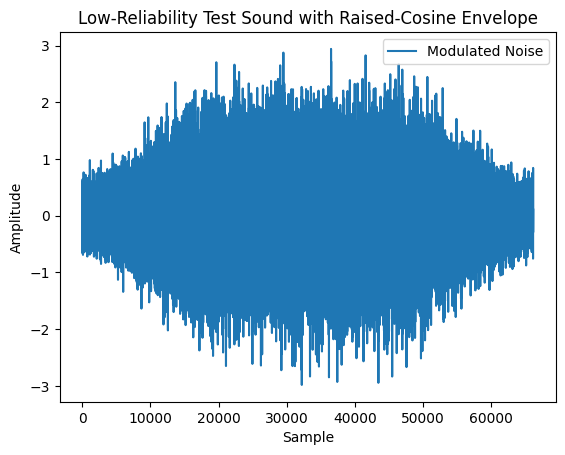

In [21]:
# Parameters
event_start = 0    # Start of the event
rise_duration = 0.5   # Duration of the rising phase
peak_duration = 0.5   # Duration of the peak phase
event_duration = rise_duration*2+peak_duration  # Duration of the event
total_duration = event_start+event_duration  # Total duration of the sound

noise_type = "white"  # Noise type
intensity = 3  
# Generate low-reliability test sound
test_sound = audio_cue.low_reliability_test_sound(total_dur=total_duration, signal_start=event_start, 
                                                  rise_dur=rise_duration, peak_dur=peak_duration, 
                                                  noise_type=noise_type, intensity=intensity)

plt.figure()
plt.plot(test_sound, label="Modulated Noise")
plt.title("Low-Reliability Test Sound with Raised-Cosine Envelope")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.legend()
plt.show()


# Play the sound
audio_cue.play_sound(test_sound)

# All in one stimulus   

In [8]:
# Parameters
total_duration = 1.4  # Total duration of the sound
#event_start = 0    # Start of the event
rise_duration = 1.2   # Duration of the rising phase
peak_duration = total_duration-2*rise_duration   # Duration of the peak phase
noise_type = "white"  # Noise type
intensity = 3       # Peak amplitude of the envelope
# Generate low-reliability test sound
test_sound = audio_cue.low_reliability_test_sound(total_dur=total_duration, 
                                                  rise_dur=rise_duration, 
                                                  peak_dur=peak_duration, 
                                                  noise_type=noise_type, 
                                                  intensity=4)

standard_sound = audio_cue.low_reliability_test_sound(total_dur=2, 
                                                  rise_dur=0, 
                                                  peak_dur=2, 
                                                  noise_type=noise_type, 
                                                  intensity=4)


# generate pre-cue sound noise for 0.1 seconds
pre_cue_sound = audio_cue.generate_noise(dur=0.15, noise_type=noise_type)
post_cue_sound = audio_cue.generate_noise(dur=0.15, noise_type=noise_type)
isi_sound = audio_cue.generate_noise(dur=np.random.uniform(0., 1.5), noise_type=noise_type)


# combine the sounds
cue_sound = np.concatenate(( test_sound, standard_sound))
# normalize the sound
def min_max_normalize(sound):
    return (sound - np.min(sound)) / (np.max(sound) - np.min(sound))
cue_sound = min_max_normalize(cue_sound)

# Play the sound
audio_cue.play_sound(cue_sound)


plt.figure()
plt.plot(cue_sound, label="Modulated Noise")
plt.title("Low-Reliability Test Sound with Raised-Cosine Envelope")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.legend()
plt.show()


ValueError: The event duration exceeds the total duration of the envelope.

# Re-Coding o the functions


22050 22050 35280 35280


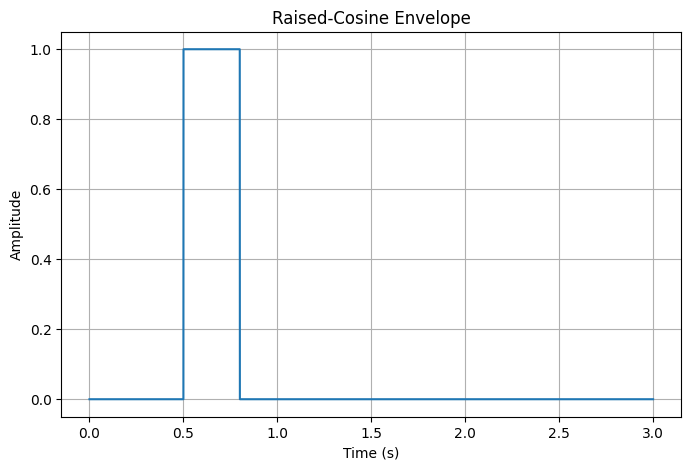

In [11]:
def raised_cosine_envelope(t_start,rise_dur,peak_dur,t_total,sample_rate=44100):
    """
    Generate a raised-cosine envelope in the time domain.
    :param t_start: Start time of the event (seconds).
    :param rise_dur: Duration of the rising phase (seconds).
    :param peak_dur: Duration of the event peak (seconds).
    :param t_total: Total duration of the total envelope (seconds).
    :param sample_rate: Sampling rate (Hz).
    :return: Raised-cosine envelope as a numpy array.
    """
    def time_to_samples(t, sample_rate=44100):
        return int(t * sample_rate)

    total_samples = np.linspace(0, t_total, int(t_total * sample_rate)) # time in terms of samples

    event_dur=2*rise_dur+peak_dur
    t_start=time_to_samples(t_start)
    rise_dur=time_to_samples(rise_dur)
    event_dur=time_to_samples(event_dur)
    peak_dur=time_to_samples(peak_dur)

    t_rise=(t_start+rise_dur)
    t_fall=(t_rise+peak_dur)
    t_end=(t_fall+rise_dur)
    
    print(t_start,t_rise,t_fall,t_end)

    envelope = np.zeros_like(total_samples)
    
    for t in range(len(envelope)):
        if t>t_start and t<=t_rise:
            envelope[t]=0.5*(1-np.cos((np.pi)*((t-t_start)/(t_rise-t_start))))
            #envelope[t]=np.sin((np.pi/2)*((t-t_start)/(t_rise-t_start)))**2
        elif t>t_rise and t<=t_fall:
            envelope[t]=1
        elif t>t_fall and t<=t_end:
            envelope[t] = 0.5*(1+np.cos((np.pi)*((t-t_fall)/(t_rise-t_start))))
    return envelope

total_dur = 3  # Total duration of the sound
sample_rate = 44100  # Samples per second
event_start = 0.5  # Start time of the event
rise_dur = 0.00  # Duration of the rising phase
peak_dur = 0.3  # Duration of the peak
intensity = 3  # Intensity of the envelope

# Generate the time vector
t = np.linspace(0, total_dur, int(total_dur * sample_rate)) # time in terms of samples
envelope = raised_cosine_envelope(event_start,rise_dur,peak_dur,total_dur,sample_rate)

# Plot the envelope
plt.figure(figsize=(8, 5))
plt.plot(t, envelope)
plt.title('Raised-Cosine Envelope')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

        

Text(0, 0.5, 'Amplitude')

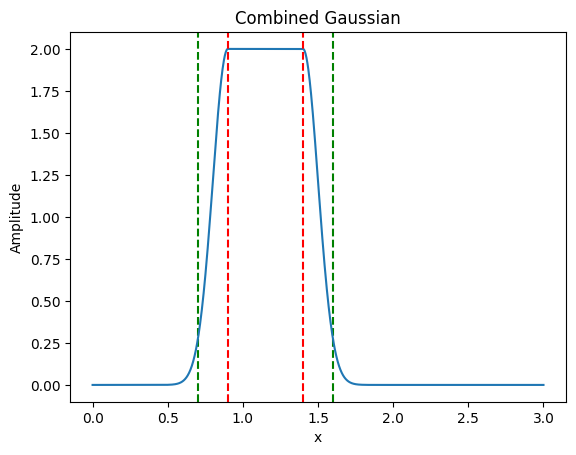

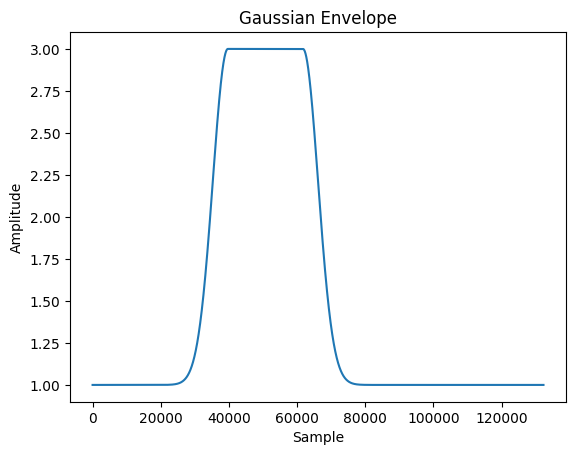

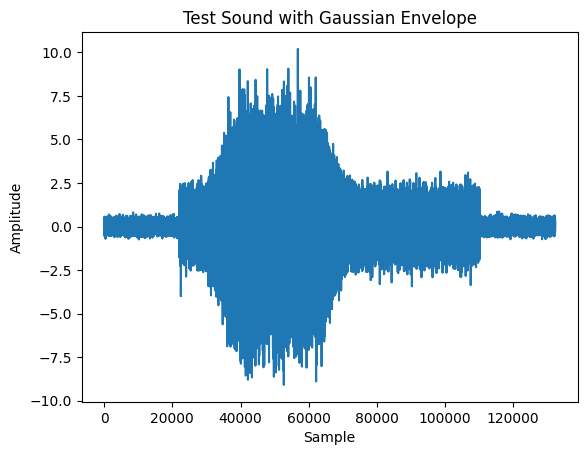

In [12]:
def gaussian_pdf(x, mu, sigma):
    return (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

def sum_of_gaussians(x, mu_list, sigma, intensity=1.0):
    gaussians = [gaussian_pdf(x, mu, sigma) for mu in mu_list]
    combined_gaussian = np.zeros_like(x)
    
    for i in range(len(mu_list) - 1):
        mask1 = (x >= mu_list[i]) & (x <= mu_list[i + 1])
        mask2 = x > mu_list[i + 1]
        gaussians[i][mask1] = np.max(gaussians[i]) #+ np.random.normal(0, 0.05, len(gaussians[i][mask1]))
        gaussians[i][mask2] = 0
        gaussians[i + 1][~mask2] = 0
        combined_gaussian += gaussians[i] + gaussians[i + 1]
        # normalize the combined gaussian
        combined_gaussian /= np.max(combined_gaussian)
    
    return combined_gaussian * intensity

def generate_gaussian_envelope(sound_dur, sample_rate, mu_list, sigma, intensity=1.0, smoothness=1.0):
    envelope = np.zeros(int(sound_dur * sample_rate))
    x = np.linspace(0, sound_dur, len(envelope))
    envelope = sum_of_gaussians(x, mu_list, sigma, intensity) # Generate the Gaussian envelope
    envelope = np.convolve(envelope, np.ones(int(smoothness)) / smoothness, mode='same')
    envelope += 1
    return envelope

# plot combined gaussian
x = np.linspace(0, 3, 1000)
mu_list = [0.9, 1.4]
sigma = 0.1
intensity = 2
combined_gaussian = sum_of_gaussians(x, mu_list, sigma, intensity)
plt.figure()

# calcuate tresholds of increasing and decreasing where the gaussian starts and ends
tresholds = [mu_list[0] - 2 * sigma, mu_list[1] + 2 * sigma]
l = [plt.axvline(t, color='g', linestyle='--') for t in tresholds]

plt.plot(x, combined_gaussian)
plt.title("Combined Gaussian")
l = [plt.axvline(mu, color='r', linestyle='--') for mu in mu_list]


plt.xlabel("x")
plt.ylabel("Amplitude")



sample_rate = 44100
sound_dur = 3 #len(test_sound) / sample_rate
signal_duration=0.5
signal_start=0.9
mu_list = [signal_start, signal_start + signal_duration] # Define the start and end of the signal
sigma = 0.1
intensity = 2# Adjust the intensity of the envelope
smoothness = 1  # Adjust the smoothness of the envelope
envelope = generate_gaussian_envelope(sound_dur, sample_rate, mu_list, sigma, intensity, smoothness)

gaussian = sum_of_gaussians(x, mu_list, sigma, intensity)


plt.figure()
plt.plot(envelope)
plt.title("Gaussian Envelope")
plt.xlabel("Sample")
plt.ylabel("Amplitude")

# Apply the envelope to the test sound
test_sound_with_envelope = test_sound * envelope

plt.figure()
plt.plot(test_sound_with_envelope)
plt.title("Test Sound with Gaussian Envelope")
plt.xlabel("Sample")
plt.ylabel("Amplitude")

#audio_cue.play_sound(test_sound_with_envelope)
